In [1]:
# add the path to the source code of the MonoForce package
import sys
sys.path.append('../src')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [3]:
from monoforce.models.dphysics import DPhysConfig

# rigid body and terrain parameters
robot = 'marv'
dphys_cfg = DPhysConfig(robot=robot)
dphys_cfg.grid_res = 0.1
dphys_cfg.d_max = 6.4
dphys_cfg.traj_sim_time = 6.0
dphys_cfg.dt = 0.01

num_trajs = dphys_cfg.n_sim_trajs
T = dphys_cfg.traj_sim_time
dt = dphys_cfg.dt
vel_max = dphys_cfg.vel_max
omega_max = dphys_cfg.omega_max
device = torch.device('cpu')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
H, W = int(2 * dphys_cfg.d_max / dphys_cfg.grid_res), int(2 * dphys_cfg.d_max / dphys_cfg.grid_res)
x_grid = torch.linspace(-dphys_cfg.d_max, dphys_cfg.d_max, H)
y_grid = torch.linspace(-dphys_cfg.d_max, dphys_cfg.d_max, W)
x_grid, y_grid = torch.meshgrid(x_grid, y_grid)
# gaussian hm
z_grid = (1.0 * torch.exp(-1.0 * ((x_grid-0)**2 + (y_grid-4)**2)) +
          4.0 * torch.exp(-5.0 * ((x_grid-1)**2 + (y_grid+2)**2)) +
          2.0 * torch.exp(-3.0 * ((x_grid+2)**2 + (y_grid+4)**2))
          ) / 3.0
# # step hm
# z_grid = torch.zeros_like(x_grid)
# z_grid[int(H/3*2):, :] = 0.4

# repeat the heightmap for each robot
x_grid = x_grid.repeat(num_trajs, 1, 1)
y_grid = y_grid.repeat(num_trajs, 1, 1)
z_grid = z_grid.repeat(num_trajs, 1, 1)
assert x_grid.shape == (num_trajs, H, W)
assert y_grid.shape == (num_trajs, H, W)
assert z_grid.shape == (num_trajs, H, W)

/home/ruslan/miniconda3/envs/mf/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643016022/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
from monoforce.models.dphysics import generate_control_inputs

# generate control inputs: linear and angular velocities
controls_front, _ = generate_control_inputs(n_trajs=num_trajs // 2,
                                                v_range=(vel_max / 2, vel_max), w_range=(-omega_max, omega_max),
                                                time_horizon=T, dt=dt)
controls_back, _ = generate_control_inputs(n_trajs=num_trajs // 2,
                                           v_range=(-vel_max, -vel_max / 2), w_range=(-omega_max, omega_max),
                                           time_horizon=T, dt=dt)
controls = torch.cat([controls_front, controls_back], dim=0)
assert controls.shape == (num_trajs, int(T / dt), 2)

print('controls: ', controls.shape)

controls:  torch.Size([64, 600, 2])


In [6]:
from monoforce.models.dphysics import DPhysics

# initialize simulator
dphysics = DPhysics(dphys_cfg, device=device)

In [7]:
# put tensors to device
z_grid = z_grid.to(device)
controls = controls.to(device)

In [8]:
from time import time

# simulate the rigid body dynamics
t0 = time()
states, forces = dphysics(z_grid=z_grid, controls=controls)
t1 = time()
Xs, Xds, Rs, Omegas, X_points = states
Fs_spring, Fs_friction = forces
print(Xs.shape, Fs_spring.shape)
print(f'Simulation took {(t1-t0):.3f} [sec] on device: {device}')

torch.Size([64, 600, 3]) torch.Size([64, 600, 223, 3])
Simulation took 1.881 [sec] on device: cpu


In [9]:
# compute trajectories costs
costs = torch.norm(Fs_spring, dim=-1).std(dim=-1).std(dim=-1)
print('costs: ', costs.shape)

costs:  torch.Size([64])


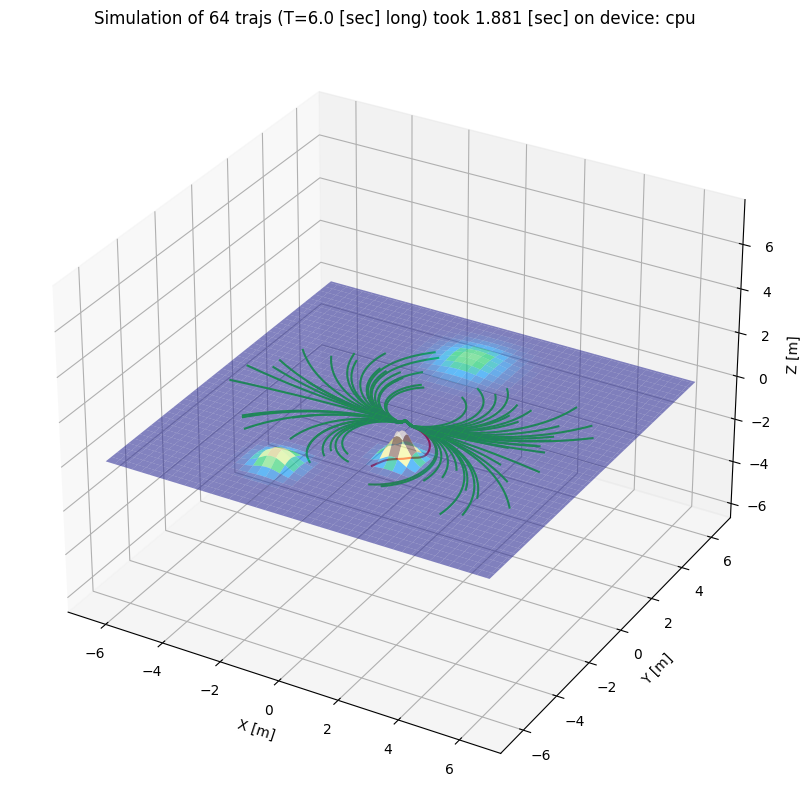

In [10]:
from monoforce.vis import set_axes_equal
from monoforce.utils import normalize

# convert costs to trajectory colors
costs_norm = np.sqrt(normalize(costs.cpu().numpy()))
colors = np.zeros((num_trajs, 3))
colors[:, 1] = 1 - costs_norm
colors[:, 0] = costs_norm

# visualize
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# plot heightmap
ax.plot_surface(x_grid[0].cpu().numpy(), y_grid[0].cpu().numpy(), z_grid[0].cpu().numpy(), alpha=0.6,
                cmap='terrain', vmin=0.0, vmax=1.0)
set_axes_equal(ax)
for i in range(num_trajs):
    ax.plot(Xs[i, :, 0].cpu().numpy(), Xs[i, :, 1].cpu().numpy(), Xs[i, :, 2].cpu().numpy(), c=colors[i])
ax.set_title(f'Simulation of {num_trajs} trajs (T={T} [sec] long) took {(t1-t0):.3f} [sec] on device: {device}')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
plt.show()